---

### **Project Description: Wheezing Detection Using Audio Signal Processing**  

In this project, we aim to classify breathing sounds as either **normal** or **wheezing**—a common symptom in asthmatic patients. The dataset consists of two folders:  
- **Normal**: Contains audio recordings of healthy breathing sounds.  
- **Wheezing**: Contains audio recordings of abnormal breathing with wheezing.  

#### **Methodology**  
1. **Feature Extraction**:  
   - We use the `librosa` library to extract relevant acoustic features (e.g., Mel-frequency cepstral coefficients - MFCCs, spectral contrast, chroma features) from the audio signals.  

2. **Model Architecture**:  
   - A **1D Convolutional Neural Network (CNN)** is trained to classify the breathing sounds based on the extracted features. CNNs are well-suited for analyzing temporal patterns in audio signals.  

3. **Expected Outcome**:  
   - The model should accurately distinguish between normal and wheezing breathing, which could assist in early asthma detection or respiratory health monitoring.  

---


In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import IPython.display as ipd

In [2]:
from pathlib import Path

# Director that contains the .wav files
dir_path = '/content/drive/MyDrive/Project_3/'
audio_classes = ['Normal', 'Wheezing']

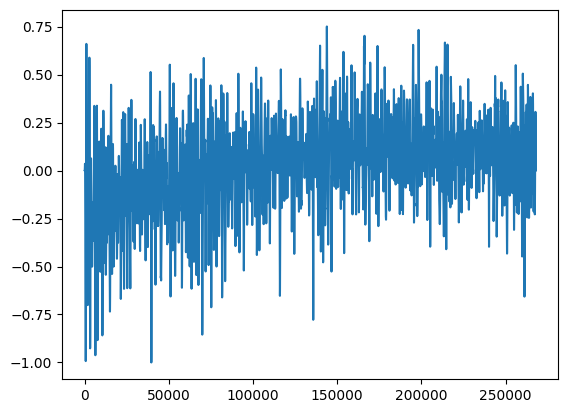

In [3]:
# Show a one of the signal
audio_path= dir_path + 'Normal/BP30_N,N,P R M,18,F.wav'
audio_data, sample_rate=librosa.load(audio_path)
plt.plot(audio_data)
plt.show()

In [4]:
def time_stretch_audio(audio, sr, target_length_sec):

    """
    Time-stretches an audio signal to a target duration (in seconds) without changing pitch.

    Args:
        audio (np.ndarray): Input audio signal.
        sr (int): Sample rate of the audio.
        target_length_sec (float): Desired output length (seconds).

    Returns:
        np.ndarray: Time-stretched audio.

    Example:
        >>> stretched_audio = time_stretch_audio(y, sr=22050, target_length_sec=2.0)
    """
    current_length = len(audio) / sr
    rate = current_length / target_length_sec
    stretched = librosa.effects.time_stretch(audio, rate=rate)
    return stretched

# Create features from audio waves
Normal = list(Path(dir_path+audio_classes[0]).rglob('*.wav'))
Wheezing = list(Path(dir_path+audio_classes[1]).rglob('*.wav'))

# For features
x = np.zeros((len(Normal)+len(Wheezing), 40, 646))
# For labels
y = np.zeros(len(Normal)+len(Wheezing))

for i, path in enumerate(Normal + Wheezing):
    audio, sr = librosa.load(path)
    audio = time_stretch_audio(audio, sr, target_length_sec=15.0)
    feature = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    x[i] = feature
    if i < len(Normal):
        y[i] = 0
    else:
        y[i] = 1

In [10]:
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(model, test_loader):
    # Set model to evaluation mode
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():  # No gradient computation needed for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Compute model outputs, and convert them to predicted classes
            outputs = model(images)
            predicted = outputs.argmax(dim=1) # Predicted class, in {0, 1}

            # Store true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute accuracy
    acc = accuracy_score(y_true, y_pred)*100
    print(f"Test Accuracy: {acc:.5f}%")

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    return acc


# Training loop
criterion = nn.CrossEntropyLoss()  # Loss function for classification
def train(model, optimizer, train_loader, num_epochs=1):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for images, labels in train_loader:
            # Transfer data to model device (if it is on GPU)
            images, labels = images.to(device), labels.to(device)

            # Perform the forward pass, backward pass and parameter updates
            loss = criterion(model(images), labels)

            # Backpropagation
            optimizer.zero_grad()  # Reset gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

In [6]:
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU(), in_channels=40):
        super(CNN, self).__init__()

        # Convolutional network
        self.sequential1 = nn.Sequential(
            # Convolution 1
            nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=40),
            activation_fn,

            # Convolution 2
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=16),
            activation_fn,
            nn.BatchNorm1d(16),
            nn.MaxPool1d(kernel_size=4),

            # Convolution 3
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=16),
            activation_fn,
            nn.BatchNorm1d(32),
            nn.MaxPool1d(kernel_size=4),
            )

        # Fully connected network
        self.sequential2 = nn.Sequential(
            nn.Linear(1056, 128),
            activation_fn,
            nn.Linear(128, 2),

        )

    def forward(self, x):
        x = self.sequential1(x)
        # Flatten x
        x = x.view(x.shape[0], -1)
        return self.sequential2(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dataloader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

x_tensor, y_tensor = torch.from_numpy(x).float(), torch.from_numpy(y).long()
# Split into validation and training set.
x_tr, x_te, y_tr, y_te = train_test_split(x_tensor, y_tensor, test_size=0.2)

train_data = TensorDataset(x_tr, y_tr)
test_data = TensorDataset(x_te, y_te)

# Batch size = 2
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [12]:
# Create model
cnn_model = CNN().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters())

# Train the model
num_epochs = 10
train(cnn_model, optimizer, train_loader, num_epochs)

print('Accuracy: ', evaluate(cnn_model, test_loader))

Epoch 1, Loss: 0.8287
Epoch 2, Loss: 0.6323
Epoch 3, Loss: 0.4605
Epoch 4, Loss: 0.3085
Epoch 5, Loss: 0.1237
Epoch 6, Loss: 0.1014
Epoch 7, Loss: 0.0987
Epoch 8, Loss: 0.0309
Epoch 9, Loss: 0.0191
Epoch 10, Loss: 0.0195
Test Accuracy: 95.74468%

Classification Report:

              precision    recall  f1-score   support

           0      0.944     0.944     0.944        18
           1      0.966     0.966     0.966        29

    accuracy                          0.957        47
   macro avg      0.955     0.955     0.955        47
weighted avg      0.957     0.957     0.957        47

Accuracy:  95.74468085106383
